# Sarcopenia Feature Selection

In [1]:
"""Module for Feature Selection in Sarcopenia Dataset."""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn import svm

import functions_features as fn

# Cargar Datos

In [2]:
# Datos modificados
datos_modificados = pd.read_csv("../data/datos_modificados.csv")

print(datos_modificados.shape)

(1253, 28)


# Create Sarcopenia Subset

In [4]:
datos_modificados['sarcewgsop'].unique()

array([2, 0, 1])

In [5]:
# Crear subconjunto de datos por sarcopenia, sin variables dependientes

# Variable dependiente
Y_sarc = datos_modificados['sarcewgsop']

# List of the true labels
labels_true = Y_sarc.unique()

# Columns to keep
sarco_cols = ['id_3', 'sexo', 'edad', 'altura', 'peso', 'imc', 'grasa',
               'músculo', 'sentadilla', 'relative_power', 'pnts_eq', 'sarcewgsop']
len(sarco_cols)

sarc_datos_mod = datos_modificados[sarco_cols]

print(sarc_datos_mod.shape)

(1253, 12)


# Preprocesamiento de los Datos Nominales y Ordinales

Ordinal Data: Scaled to ensure equal weights and make comparison between values easier.

In [6]:
# ordinal data - change scales to match (0-10) - id_3

# Check value ranges before
print(f"id_3 values: {sorted(sarc_datos_mod['id_3'].unique())}")

print("\n---- Change Applied ----\n")
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0,10))

# Fit and transform columns
d = scaler.fit_transform(sarc_datos_mod[['id_3']])

# Cast as DataFrame and round
sarc_datos_mod[['id_3']] = pd.DataFrame(d, columns=['id_3']).round(2)

# Check value ranges
print(f"{'id_3'} values: {sorted(sarc_datos_mod['id_3'].unique())}")

id_3 values: [1, 2, 3]

---- Change Applied ----

id_3 values: [0.0, 5.0, 10.0]


/tmp/ipykernel_49482/3129221616.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarc_datos_mod[['id_3']] = pd.DataFrame(d, columns=['id_3']).round(2)


In [7]:
# Save sarco subset
sarc_datos_mod.to_csv('../data/sarco/sarc_datos_mod.csv')

# Remove sarcewgsop to create training data subset
X_sarco_datos_mod = sarc_datos_mod.drop('sarcewgsop', axis=1)

# Save subsets
X_sarco_datos_mod.to_csv('../data/sarco/X_sarco_datos_mod.csv')

attributes = list(X_sarco_datos_mod.columns)
len(attributes)

11

## Estandarizar los datos
To prepare data for:
- agglomerative clustering
- SVM feature selection

In [8]:
# Standardize
X_sarco_norm_mod = fn.standardize_yo(X_sarco_datos_mod, '/sarco/X_sarco_norm_mod.csv', attributes)

# Check out the results
X_sarco_norm_mod.describe().transpose().head()

,count,mean,std,min,25%,50%,75%,max
id_3,1253.0,0.024606,0.354105,-0.932310,-0.285628,0.193117,0.298891,0.656919
sexo,1253.0,-0.054460,0.236402,-0.299473,-0.155553,-0.119350,-0.090540,0.881559
edad,1253.0,-0.006139,0.338679,-0.920330,-0.245440,0.048419,0.242595,0.804995
altura,1253.0,-0.021860,0.308038,-0.725144,-0.247107,-0.033547,0.217481,0.738266
peso,1253.0,-0.014269,0.284669,-0.646232,-0.261335,-0.011682,0.212666,0.619861


# Selección de Variables

## Filter method: Pearson correlation between Y (cut_off_points) and features

In [9]:
# Get correlation between all variables
cor_mod = sarc_datos_mod.corr(method='spearman')

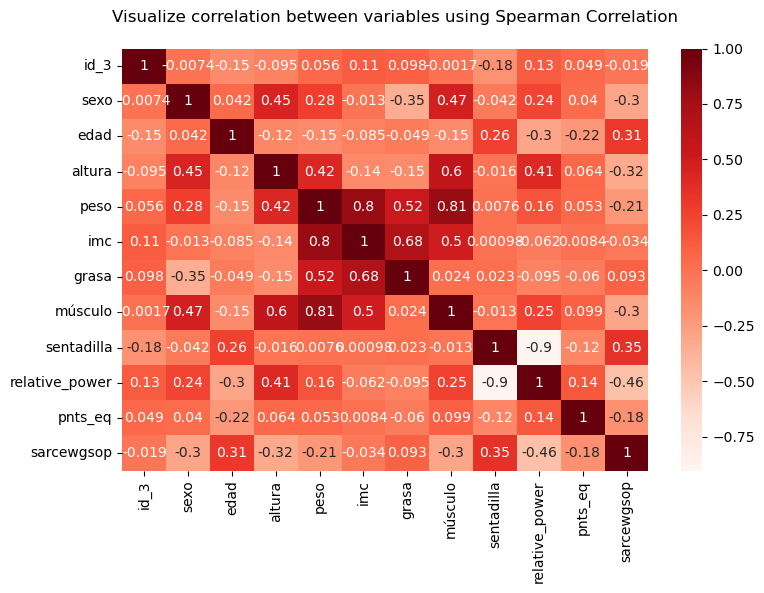

In [10]:
# Visualize correlation between variables using Spearman Correlation
plt.figure(figsize=(8,6))
sns.heatmap(cor_mod, annot=True, cmap="Reds")

plt.suptitle('Visualize correlation between variables using Spearman Correlation')
plt.tight_layout();

### Check correlation with target variable

In [11]:
ranked_corr, correlated_features = fn.get_cor_variables(cor_mod, 'sarcewgsop', 0.3)

print(ranked_corr)
print(correlated_features)

                sarcewgsop
edad              0.308608
altura            0.320903
músculo           0.304080
sentadilla        0.350565
relative_power    0.457293
['edad', 'altura', 'músculo', 'sentadilla', 'relative_power']


### Check for correlation between select features

In [12]:
# Check if the correlated features are correlated with each other
sarc_datos_mod[correlated_features].corr(method='spearman')

,edad,altura,músculo,sentadilla,relative_power
edad,1.000000,-0.122543,-0.151345,0.262215,-0.298236
altura,-0.122543,1.000000,0.595203,-0.015987,0.408460
músculo,-0.151345,0.595203,1.000000,-0.013017,0.253397
sentadilla,0.262215,-0.015987,-0.013017,1.000000,-0.902007
relative_power,-0.298236,0.408460,0.253397,-0.902007,1.000000


Hay características correlacionadas:
- relative_power y sentadilla (-0.90)
- músculo y altura (0.59)

**Note:** Entonces, debo quitar sentadilla y músculo para eliminar las que son más correlacionadas.<br>

In [13]:
correlated_features.remove('sentadilla')
correlated_features.remove('músculo')

sarc_datos_mod[correlated_features].corr(method='spearman')

,edad,altura,relative_power
edad,1.000000,-0.122543,-0.298236
altura,-0.122543,1.000000,0.408460
relative_power,-0.298236,0.408460,1.000000


In [14]:
# Subconjunto de los Datos Seleccionados con Pearson Correlación
X_cor_mod = sarc_datos_mod[correlated_features]

# Save to csv
X_cor_mod.to_csv('../data/sarco/X_cor_mod.csv')

In [15]:
def df_with_corr_feat(ranked_data):
    """Function to remove the correlated features from the ranking dataframe."""

    ranked_data = ranked_data.drop(['sentadilla', 'músculo'], axis=0)
    ranked_data = ranked_data.sort_values('sarcewgsop', ascending=False)\
                    .reset_index()\
                    .rename(columns={'index':'feat','sarcewgsop':'corr'})\
                    .drop('corr', axis=1)
    return ranked_data

In [16]:
# Get feature rankings with pearson corr
ranked_corr_mod_nhi = df_with_corr_feat(ranked_corr)

# Create feature rank dataframe
feature_ranking_mod = fn.create_rank_df(ranked_corr_mod_nhi, attributes)

/mnt/c/Users/dmdeq/Documents/evida/evida/code/functions_features.py:94: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  feature_ranking.loc[feature]['corr'] = rank


## Wrapper method: Visualize p-values of features using OLS model

Feed the features to the selected Machine Learning algorithm (OLS:ordinary least squares) and based on the model performance features are added/removed.<br> 
Lowest p-value = more significant

**Note** Consider using a model other than OLS to select features, because OLS is for linear regression. Viz data and see if it makes sense.

Some of this work is pulled from a TowardsDataScience blog [here](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)

**Remove feature with highest p-value.** Build the model again with remaining features, and run again until there are no remaining features with p-value above 0.05. A p-value of 0.05 is normal behavior. Anything less would be significant.

In [17]:
# Get ranked features using ols
ranked_ols_mod, sel_feat_ols_mod = fn.ols_feature_selection(X_sarco_datos_mod, Y_sarc)

# Get feature ranking using OLS
feature_ranking_mod = fn.add_to_feat_rank_df(feature_ranking_mod, ranked_ols_mod, 'ols')

# Create data subset of only OLS selected correlated features
X_cor_ols_mod = sarc_datos_mod[sel_feat_ols_mod]

# Save to csv
X_cor_ols_mod.to_csv('../data/sarco/X_cor_ols_mod.csv')

## Random Forest Method
Calculate the importance of each feature in a decision tree, then average that features importance with all the other trees in the forest.

In [18]:
# create datasets of select features using random forest and get feature ranking
X_forest_mod, ranked_for = fn.random_for_feat_sel(X_sarco_datos_mod,
                                                  Y_sarc,
                                                  '/sarco/X_forest_mod.csv')

# add Random Forest ranking data to selected features dataframe
feature_ranking_mod = fn.add_to_feat_rank_df(feature_ranking_mod, ranked_for, 'for')

# SVM Feature Selection
[Paper](http://data.conferenceworld.in/ICSTM4/P165-172.pdf) that mentions using SVM for feature extraction.
[StackOverflow](https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn) feature extraction example.

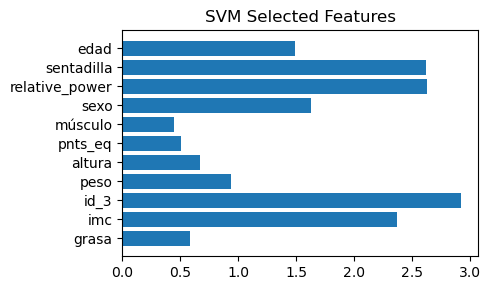

In [19]:
# fit data to model
model = svm.SVC(kernel='linear')
model.fit(X_sarco_norm_mod, Y_sarc)

# convert to df and sub abs. value of coefficients
coef_svm = pd.DataFrame(model.coef_).transpose()
coef_svm['sum_abs'] = coef_svm.abs().sum(axis=1) # sum of absolute value of coef's

fig, ax = plt.subplots(figsize=(5,3))
coef_abs = coef_svm['sum_abs']

coef_svm, names = zip(*sorted(zip(coef_abs, attributes)))
ax.barh(range(len(names)), coef_abs, align='center')
ax.set_yticks(range(len(names)), names)
ax.set_title('SVM Selected Features')

plt.tight_layout()
#plt.savefig('../plots/sarco/svm_select_features')
plt.show()

In [20]:
# create datasets of select features using SVM and get feature ranking
X_svm_mod, ranked_svm_mod = fn.svm_feat_sel(X_sarco_norm_mod,
                                            X_sarco_datos_mod,
                                            Y_sarc,
                                            'sarco/X_svm_mod.csv',
                                            .65
                                           )

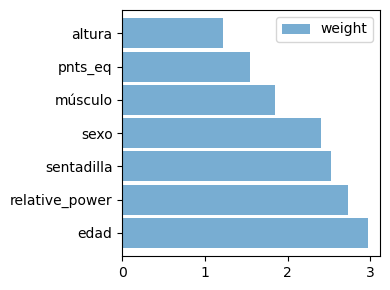

In [21]:
fig, ax = plt.subplots(figsize=(4,3))

ranked_svm_mod.plot.barh(x='feat', ax=ax, width=0.9, alpha=0.6)
ax.set_ylabel("")

plt.tight_layout()

In [22]:
# Add SVM ranking data to selected features dataframe
feature_ranking_mod = fn.add_to_feat_rank_df(feature_ranking_mod, ranked_svm_mod, 'svm')

# compute final ranking with combined feature selection methods
feature_ranking_mod = fn.compute_ranking(feature_ranking_mod, 'sarco/feature_ranking_mod.csv')

In [23]:
index_names = list(feature_ranking_mod.index)
index_names = [x.replace('_', ' ') for x in index_names]
index_names = [x.title() for x in index_names]

column_names = {'corr': 'Pearson', 'ols': 'Least Squares',
                'for': 'Random Forest', 'svm': 'SVM',
                'rank':'Rank', 'rank_sum':'Rank Sum'}

feature_ranking_mod.rename(columns=column_names, inplace=True)

feature_ranking_mod['Variable'] = index_names
feature_ranking_mod.set_index('Variable', inplace=True)
feature_ranking_mod

,Pearson,Least Squares,Random Forest,SVM,Rank Sum,Rank
Variable,,,,,,
Relative Power,1,3,1,2,7,0.142857
Edad,3,1,3,1,8,0.125000
Sentadilla,11,7,2,3,23,0.043478
Altura,2,11,4,7,24,0.041667
Sexo,11,2,11,4,28,0.035714
Peso,11,5,5,11,32,0.031250
Pnts Eq,11,4,11,6,32,0.031250
Músculo,11,11,6,5,33,0.030303
Imc,11,6,11,11,39,0.025641


In [24]:
new_index = ['Relative Power', 'Age', '5STS', 'Height',
             'Sex', 'Weight', 'Points (balance)', 'Muscle',
             'BMI', 'Fat Mass', 'Socioeconomic Index (3)']

feature_ranking_mod['Variable'] = new_index
feature_ranking_mod.set_index('Variable', inplace=True)

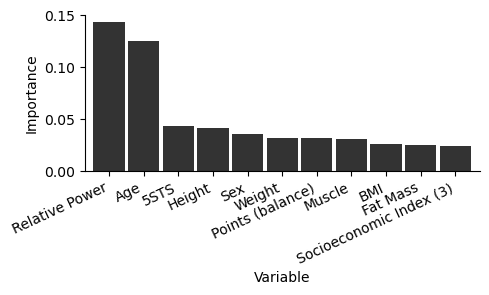

In [25]:
fig, ax = plt.subplots(figsize=(5,3))

feature_ranking_mod['Rank'].plot.bar(stacked=False, width=.90,
                                     rot=25, ax=ax, alpha=0.8, color=['black'])

plt.setp(ax.get_xticklabels(), ha="right")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Variable")
ax.set_ylabel("Importance")

fig.tight_layout()
#plt.savefig('../plots/sarco/feature_importance.png');

# Visualize Selected Features

In [ ]:
# Get features and counts
feature_counts_mod, feat_mod = fn.feature_counts(X_cor_mod,
                                                 X_cor_ols_mod,
                                                 X_forest_mod,
                                                 X_svm_mod)

In [27]:
feat_mod['Variable'] = new_index
feat_mod.set_index('Variable', inplace=True)

column_names = {'pearson': 'Spearman', 'ols': 'OLS',
                'random_forest': 'RF',
                'svm': 'SVM', 'count':'Count'}

feat_mod.rename(columns=column_names, inplace=True)

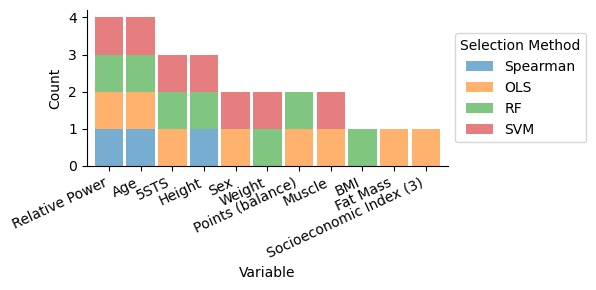

In [28]:
fig, ax = plt.subplots(figsize=(6,3))
feat_mod[['Spearman', 'OLS', 'RF', 'SVM']].plot.bar(stacked=True,
                                                              width=.90,
                                                              rot=25,
                                                              ax=ax,
                                                              alpha=0.6)

plt.setp(ax.get_xticklabels(), ha="right")
ax.set_xlabel("Variable")
ax.set_ylabel("Count")
ax.set_yticks([0,1,2,3,4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), title='Selection Method')

fig.tight_layout()
#plt.savefig('../plots/sarco/feature_counts.png');

# Dimensionality Reduction / PCA
Una forma de derivir un conjunto de caracterìsticas de baja dimensión de un gran congunto de variables.<br>
La primera dirección componente principal de los datos es aquella en la que las observasiones varían más.<br>

We only need to reduce down to 3 components to explain more than 95% of the data.

In [29]:
# Get dataset using PCA
x_pca_95_mod =  fn.get_components(X_sarco_datos_mod, '../data/sarco/X_pca_95_mod.csv')

1 components explain 59.18% of the data
2 components explain 74.75% of the data
3 components explain 88.35% of the data
4 components explain 94.87% of the data
5 components explain 98.01% of the data



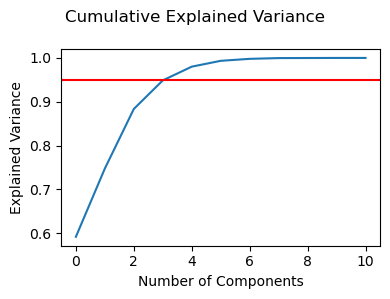

In [30]:
# 25 components to reduce to
pca = PCA(n_components=11)
pca.fit(X_sarco_datos_mod)

X_pca_12 = pd.DataFrame(pca.transform(X_sarco_datos_mod))

fig = plt.figure(figsize=(4,3))
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.suptitle('Cumulative Explained Variance')

fig.tight_layout()
plt.show()